> # AIDA with Transfer Learning

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns

import urllib.request
from urllib.parse import urlparse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

#https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.models import Model
from keras import metrics
from keras.callbacks import ModelCheckpoint, TensorBoard
from numba import cuda

import sklearn.model_selection as skms
from sklearn.utils import class_weight

#from wcs.google import google_drive_share
import urllib.request
from urllib.parse import urlparse

#from google.colab import drive
import src.helper.helper as hlp
import src.helper.const as const
import datetime as dt
import time

import warnings
warnings.simplefilter(action='ignore')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Configuration

In [2]:
# Config
USE_MOST_POPULAR = True
NUM_MOST_POPULAR = 50000

DP_TFDATA = "Data pipeline using tf.data"
DP_IMGGEN = "Data pipeline using tf.keras.ImageGenerator"
DP = DP_TFDATA

LR = 1e-5 # Keep it small when transfer learning
BATCH_SIZE = 64
EPOCHS = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

IMG_DIMS = [299, 299]
IMG_CHANNELS = 3  # Keep RGB color channels to match the input format of the model
LABEL_COLS = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
              'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
              'Thriller', 'War', 'Western']

DIR = './'
DATA_DIR_POSTER = DIR + '../data/raw/posters_v3/'
DATA_DIR_INTERIM = DIR + "../data/interim/"
DATA_DIR_RAW = DIR + "../data/raw/"
MODEL_DIR = DIR + "../models/"
BASE_DIR = DIR
IMAGES_DIR = DATA_DIR_POSTER
SEED = const.SEED
TENSORBOARD_LOGDIR = DIR + "tensorboard_logs/scalars/"

pd.set_option('display.max_colwidth', None)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Create virtual GPUs
    try:
        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)],
            #Error: gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],
        )
        
        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)],
            #Error: gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],            
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2 Physical GPU, 4 Logical GPUs


# Helper

In [4]:
def init_devices():
    # Check GPUs
    num_gpu = len(tf.config.list_physical_devices('GPU'))
    print("Num GPUs Available: ", num_gpu)

    gpus = tf.config.list_physical_devices('GPU')
    print(f"{f'Physical GPU Device: {gpus}' if gpus else 'No GPU available'}")

    if gpus:
        # Restrict TensorFlow to only allocate 6GB of memory on the first GPU
        try:
            """
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Set memory growth for {len(gpus)} physical GPU(s)")
            """
            mem_lim = 10*1024  # 6GB
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_lim)])        
            #logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            #print(f"Set memory usage to {mem_lim/1000} GB for {len(gpus)} physical GPU(s) -> {len(logical_gpus)} logical GPU(s)")
            print(f"Set memory usage to {mem_lim/1000} GB for {len(gpus)} physical GPU(s)")

        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
        print("GPU(s) will be automatically choosen for model calculations below.")
    else:
        print("CPUs will be automatically choosen for model calculations below.")

# Datapipeline based on tf.data

In [5]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(DATA_DIR_POSTER + filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=IMG_CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_DIMS[0], IMG_DIMS[1]])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label


def create_dataset(filenames, labels, cache=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if cache == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# Preproc

In [6]:
# Read train/eval datasets from file
df = pd.read_parquet(DATA_DIR_INTERIM + "df_train_unbalanced_v3.gzip")
df.shape

(273876, 32)

In [17]:
# Read test datasets from file
df_test = pd.read_parquet(DATA_DIR_INTERIM + "df_test_v3.gzip")
df_test.shape

RuntimeError: Decompression 'SNAPPY' not available.  Options: ['GZIP', 'UNCOMPRESSED']

In [8]:
# Get 50000 most popular movies
if USE_MOST_POPULAR:
    df = df.sort_values(by='popularity', ascending=False).iloc[:NUM_MOST_POPULAR]  # first NUM_MOST_POPULAR most release_date
    print(df.shape)

(50000, 32)


In [9]:
# Add genre names
map_genre = {
    28:"Action", 12:"Adventure", 16:"Animation", 35:"Comedy", 80:"Crime", 99:"Documentary", 18:"Drama", 10751:"Family",
    14:"Fantasy", 36:"History", 27:"Horror", 10402:"Music", 9648:"Mystery", 10749:"Romance", 878:"Science Fiction", 10770:"TV Movie",
    53:"Thriller", 10752:"War", 37:"Western"}

def create_genre_names(in_str):
    if isinstance(in_str, list):
        return [map_genre[id] for id in in_str]
    else:
        # it must be string
        if in_str is None or len(in_str) == 0:
            return []
        else:
            ret = eval(in_str)
            return [map_genre[id] for id in ret]
    
df['genre_names'] = df['genre_id'].map(create_genre_names)
df[LABEL_COLS+['genre_names']].head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,genre_names
260691,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,"[Animation, Adventure, Fantasy, Family, Action, Drama]"
53765,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"[Action, Comedy, Family, Animation, Adventure]"
218484,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Fantasy, Action, Adventure]"
119713,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[Comedy]
153425,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Fantasy, Action, Adventure]"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 260691 to 123786
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               50000 non-null  int64         
 1   original_title   50000 non-null  object        
 2   release_date     50000 non-null  datetime64[ns]
 3   popularity       50000 non-null  float64       
 4   adult            50000 non-null  bool          
 5   video            50000 non-null  bool          
 6   poster_url       50000 non-null  object        
 7   poster_exists    50000 non-null  bool          
 8   filename         50000 non-null  object        
 9   genre_id         50000 non-null  object        
 10  genre_ids2       50000 non-null  object        
 11  genre_ids2_list  50000 non-null  object        
 12  genre_id_count   50000 non-null  int64         
 13  Action           50000 non-null  int64         
 14  Adventure        50000 non-null 

 Create ImageGenerators

In [11]:
print(DP)
df_train, df_valid = skms.train_test_split(df, test_size=0.01, random_state=SEED)
df_train.head()

Data pipeline using tf.data


,id,original_title,release_date,popularity,adult,video,poster_url,poster_exists,filename,genre_id,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,genre_names
43064,356841,Checkmate,2015-07-03,7.107,False,False,https://www.themoviedb.org/t/p/w500//gG4iRaSrivB7hWtzwkM9UsQ7nma.jpg,True,gG4iRaSrivB7hWtzwkM9UsQ7nma.jpg,"[53, 28, 80]",...,0,0,0,0,0,0,1,0,0,"[Thriller, Action, Crime]"
120358,486164,Ratpocalypse,2015-09-21,6.532,False,False,https://www.themoviedb.org/t/p/w500//tAqFsEnFjY4wXvmTpGFyfzce0ho.jpg,True,tAqFsEnFjY4wXvmTpGFyfzce0ho.jpg,"[878, 14]",...,0,0,0,0,1,0,0,0,0,"[Science Fiction, Fantasy]"
11042,410118,Cave,2016-09-02,20.670,False,False,https://www.themoviedb.org/t/p/w500//4RbStTnnZCDKLNqf9iPNbOBf1Bn.jpg,True,4RbStTnnZCDKLNqf9iPNbOBf1Bn.jpg,"[12, 53]",...,0,0,0,0,0,0,1,0,0,"[Adventure, Thriller]"
122238,58149,Modern Inventions,1937-05-29,4.378,False,False,https://www.themoviedb.org/t/p/w500//dRuCC4yAgIGRjsTz8evhNsCXM3d.jpg,True,dRuCC4yAgIGRjsTz8evhNsCXM3d.jpg,"[10751, 16]",...,0,0,0,0,0,0,0,0,0,"[Family, Animation]"
112019,241843,Cooties,2014-10-10,18.279,False,False,https://www.themoviedb.org/t/p/w500//qnH3SCfb3ePz9qM8BvBtq9JLLXY.jpg,True,qnH3SCfb3ePz9qM8BvBtq9JLLXY.jpg,"[35, 27]",...,1,0,0,0,0,0,0,0,0,"[Comedy, Horror]"


In [12]:
if DP == DP_IMGGEN:
    datagen = ImageDataGenerator(rescale=1 / 255.)#, validation_split=0.1)
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="genre_id",
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True,
        class_mode="categorical",    
        target_size=(299, 299),
        subset='training',
        validate_filenames=True
    )
    
    valid_generator = datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col="genre_id",
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False,
        class_mode="categorical",
        target_size=(299, 299),
        subset='training',
        validate_filenames=True
    )
else:
    X_train = df_train.filename.to_numpy()
    y_train = df_train[LABEL_COLS].to_numpy()
    X_valid = df_valid.filename.to_numpy()
    y_valid = df_valid[LABEL_COLS].to_numpy()
    
    train_generator = create_dataset(X_train, y_train, cache=True)
    valid_generator = create_dataset(X_valid, y_valid, cache=True)
    
    print(f"{len(X_train)} training datasets, using {y_train.shape[1]} classes")
    print(f"{len(X_valid)} validation datasets, unsing {y_valid.shape[1]} classes")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49500 training datasets, using 19 classes
500 validation datasets, unsing 19 classes


<AxesSubplot:title={'center':'Label distributions'}>

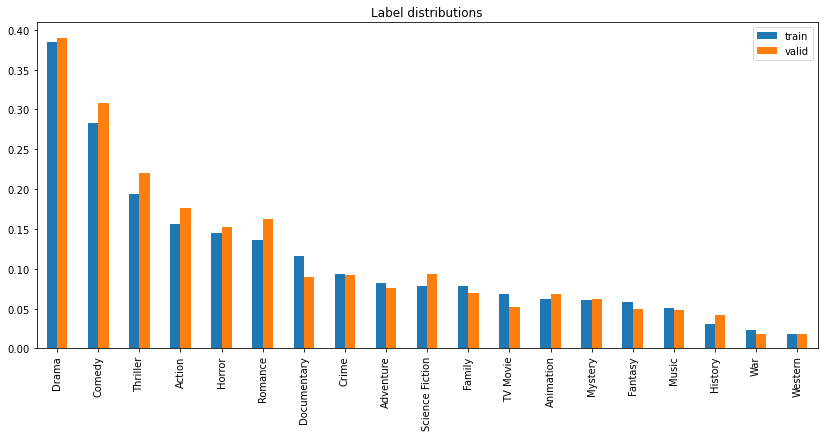

In [13]:
# Show label distribution
df_tmp = df = pd.DataFrame(
    {
        'train': df_train[LABEL_COLS].sum()/len(df_train), 
        'valid': df_valid[LABEL_COLS].sum()/len(df_valid), 
        'test': df_test[label_columns].sum()/len(df_test)
    }, 
    index=LABEL_COLS
)
df_tmp.sort_values('train', ascending=False).plot.bar(figsize=(14,6), title='Label distributions')

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49500 entries, 43064 to 173900
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               49500 non-null  int64         
 1   original_title   49500 non-null  object        
 2   release_date     49500 non-null  datetime64[ns]
 3   popularity       49500 non-null  float64       
 4   adult            49500 non-null  bool          
 5   video            49500 non-null  bool          
 6   poster_url       49500 non-null  object        
 7   poster_exists    49500 non-null  bool          
 8   filename         49500 non-null  object        
 9   genre_id         49500 non-null  object        
 10  genre_ids2       49500 non-null  object        
 11  genre_ids2_list  49500 non-null  object        
 12  genre_id_count   49500 non-null  int64         
 13  Action           49500 non-null  int64         
 14  Adventure        49500 non-null  

In [15]:
from sklearn.utils import class_weight

#In order to calculate the class weight do the following
class_weights = class_weight.compute_class_weight('balanced',
                                                  LABEL_COLS, # np.array(list(train_generator.class_indices.keys()),dtype="int"), 
                                                  np.array(df_train.genre_names.explode()))

class_weights = dict(zip(list(range(len(class_weights))), class_weights))
number_of_classes = len(LABEL_COLS)
pd.DataFrame({'weight': [i[1] for i in class_weights.items()]}, index=[LABEL_COLS[i[0]] for i in class_weights.items()])

,weight
Action,0.713616
Adventure,1.361397
Animation,1.799513
Comedy,0.394025
Crime,1.189462
Documentary,0.965216
Drama,0.290082
Family,1.424285
Fantasy,1.915691
History,3.652618


# Create model

In [16]:
def model_create():
    base_inc_res = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(299,299,3))
    base_inc_res.trainable = False
    base_xception = Xception(include_top=False, weights='imagenet', pooling='avg', input_shape=(299, 299, 3))
    base_xception.trainable = False
    
    inputs = keras.Input(shape=(299,299,3))
    x1 = preprocess_input_inc_res(inputs)
    x1 = base_inc_res(x1)
    x1 = layers.BatchNormalization()(x1)
    
    x2 = preprocess_input_xception(inputs)
    x2 = base_xception(x2)
    x2 = layers.BatchNormalization()(x2)
    
    x = K.concatenate([x1, x2])
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(19, activation='sigmoid')(x)
    
    model_name = "InceptionResNetV2_Customized"
    return keras.Model(inputs=inputs, outputs=x, name=model_name)
    return model, model_name

model_test = model_create()

ImportError: `load_weights` requires h5py when loading weights from HDF5.

Finally, we implemented a standard DenseNet-169 architecture with similar modifications. The final
fully-connected layer of 1000 units was once again replaced by 3 sequential fully-connected layers of
3
1024, 128, and 7 units with ReLU, ReLU, and sigmoid activations respectively. The entire model
consists of 14,479,943 parameters, out of which, 14,321,543 were trainable.

In [ ]:
!mkdir model_checkpoints

In [ ]:
#tf.debugging.set_log_device_placement(True)
l_rtc_names = [            
    "2-GPU_MirroredStrategy",
    "2-GPU_CentralStorageStrategy",        
    "1-GPU",    
    "56_CPU"
    "2-GPU_MirroredStrategy_NCCL-All-Reduced",
]
l_rtc = [        
    tf.distribute.MirroredStrategy().scope(),    
    tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce()).scope(),                
    tf.device("/GPU:0"),       
    tf.device("/CPU:0"),
    tf.distribute.experimental.CentralStorageStrategy().scope(),        
]
for i, runtime_context in enumerate(l_rtc):   
    print(f"Runtime Context: {l_rtc_names[i]}")

    # Start time measurement
    tic = time.perf_counter()

    # Init available GPUs or CPUs
    #init_devices()
    
    # Create and train model
    with runtime_context:    
        model, model_name = model_create()

        # Define Tensorflow callback log-entry
        model_name_full = f"{model.name}_{l_rtc_names[i]}_{dt.datetime.now().strftime('%Y%m%d-%H%M%S')}"
        tb_logdir = f"{TENSORBOARD_LOGDIR}{model_name_full}"
        #checkpoint_path = "model_checkpoints/saved-model-06-0.46.hdf5"
        #model.load_weights(checkpoint_path)

        # mark loaded layers as not trainable
        # except last layer
        leng = len(model.layers)
        print(leng)
        for i,layer in enumerate(model.layers):
            if leng-i == 5:
              print("stopping at",i)
              break
            layer.trainable = False

        # Def metrics
        threshold = 0.35
        f1_micro = tfa.metrics.F1Score(num_classes=19, average='micro', name='f1_micro',threshold=threshold), 
        f1_macro = tfa.metrics.F1Score(num_classes=19, average='macro', name='f1_macro',threshold=threshold)
        f1_weighted = tfa.metrics.F1Score(num_classes=19,  average='weighted', name='f1_score_weighted',threshold=threshold)

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
            loss="binary_crossentropy", 
            metrics=["categorical_accuracy",
                     tf.keras.metrics.AUC(multi_label = True),#,label_weights=class_weights),
                     f1_micro,
                     f1_macro,
                     f1_weighted,
                    ])

        print("create callbacks")
        #filepath = "model_checkpoints/{model_name}_saved-model-{epoch:02d}-{val_f1_score_weighted:.2f}.hdf5"
        #cb_checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score_weighted', verbose=1, save_best_only=True, mode='max')

        cb_tensorboard = TensorBoard(
            log_dir = tb_logdir,
            histogram_freq=0, 
            update_freq='epoch',
            write_graph=True, 
            write_images=False)
        #callbacks_list = [cb_checkpoint, cb_tensorboard]
        #callbacks_list = [cb_checkpoint]
        callbacks_list = [cb_tensorboard]

        # Train model
        print("model fit")
        history = model.fit(
            train_generator,
            validation_data=valid_generator,
            epochs=EPOCHS,
            # reduce steps per epochs for faster epochs
            #steps_per_epoch = math.ceil(266957 / BATCH_SIZE /8),
            #class_weight = class_weights,
            callbacks=callbacks_list,
            use_multiprocessing=False
        )

        print("Saving final model")
        #model.save(MODEL_DIR + model_name_full)

        print("Saving final model weights")
        #model.save_weights(MODEL_DIR + model_name_full + ".ckpt")

        # Measure time of loop
        toc = time.perf_counter()
        secs_all = toc - tic
        mins = int(secs_all / 60)
        secs = int((secs_all - mins*60))
        print(f"Time spend for current run: {secs_all:0.4f} seconds => {mins}m {secs}s")

        #print("Reset GUPs")
        #cuda.select_device(0)
        #cuda.reset()
        #device = cuda.get_current_device()
        #device.reset()

In [ ]:
y_pred = model.predict(valid_generator)

In [ ]:
y_pred.shape

In [ ]:
y_true = [ [1 if i in e else 0 for i in range(19)] for e in valid_generator.labels]
y_true = np.array(y_true)

In [ ]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 10)

pd.DataFrame({
    'threshold': ths, 
    'f1-micro': [f1_score(y_true, (y_pred > th)*1., average="micro") for th in ths],
    'f1-weighted': [f1_score(y_true, (y_pred > th)*1., average="weighted") for th in ths],
    'class' : "all"
    }
)

In [ ]:
from sklearn.metrics import f1_score

ths = np.linspace(0.1, 0.5, 9)

df_ths = pd.DataFrame({'threshold' : ths}
)

for cl in range(19):
    col = pd.DataFrame({f'f1-class_{cl}': [f1_score(y_true[:,cl], (y_pred[:,cl] > th)*1.) for th in ths]          
                       })
    df_ths=pd.concat([df_ths,col],axis="columns")

df_ths.style.highlight_max(color = 'lightgreen', axis = 0)
df_ths

In [ ]:
argmax_index=df_ths.iloc[:,1:].idxmax(axis=0)
class_thresholds = df_ths.threshold[argmax_index].values
class_thresholds

In [ ]:
f1_score(y_true, (y_pred > class_thresholds)*1., average="micro")

In [ ]:
f1_score(y_true, (y_pred > class_thresholds)*1., average="weighted")

In [ ]:
y_true = np.array(y_true)

In [ ]:
y_true[:,3].shape

In [ ]:
y_pred[:,3].shape

In [ ]:
#df_genre.sort_values(by="count",ascending=False)[:7]

In [ ]:
#valid_generator.class_indices.keys()

In [ ]:
top_n_genre_ids = df_genre.sort_values(by="count",ascending=False)[:7]
display(top_n_genre_ids)
top_n_genre_col_pos = {i:map_gender[str(e)] for i,e in enumerate(list(valid_generator.class_indices.keys())) if e in top_n_genre_ids.values}
display(top_n_genre_col_pos)
#mask_top_n_genre_ids = [(e in top_n_genre_ids.values) for e in list(valid_generator.class_indices.keys())]
#mask_top_n_genre_ids

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=19
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], 
                                  y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'b', 'g', 'r', 'c', 'm', 'y', 'k'])

for i, color in zip(top_n_genre_col_pos.keys(), colors):#zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             #''.format(map_gender[str(i)], roc_auc[i]))
             ''.format(top_n_genre_col_pos[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# f1 

In [ ]:
df[df.filename=='wdju5uQUMy2jjeqdKroI6VklYbY.jpg']

In [ ]:
!pip install -U tensorboard-plugin-profile